<a href="https://colab.research.google.com/github/ram130849/object_detection_using_faster_rcnn/blob/main/ExDark_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q -U opencv-python
!pip install -q -U albumentations
!pip install -q -U bounding-box

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
! git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 322835, done.
remote: Counting objects: 100% (820/820), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 322835 (delta 673), reused 791 (delta 660), pack-reused 322015
Receiving objects: 100% (322835/322835), 654.53 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (296703/296703), done.


In [4]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [5]:
import pandas as pd
import numpy as np
import re
# from tqdm.notebook import tqdm
import tqdm
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import os
import shutil
from sklearn import model_selection, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import utils
from torch.utils.data import DataLoader,Dataset
from skimage import io, transform

from torchvision.models import resnet101,ResNet101_Weights
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import time
import shutil
import albumentations as A
from albumentations.pytorch import ToTensorV2
from bounding_box import bounding_box as bb
from PIL import Image

In [7]:
!unzip '/content/gdrive/MyDrive/ExDark/ExDark.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ExDark/Motorbike/2017_07361.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2017_07361.jpg  
  inflating: /content/ExDark/Motorbike/2015_06160.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_06160.jpg  
  inflating: /content/ExDark/Motorbike/2015_05864.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05864.jpg  
  inflating: /content/ExDark/Motorbike/2015_05870.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05870.jpg  
  inflating: /content/ExDark/Motorbike/2015_05858.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05858.jpg  
  inflating: /content/ExDark/Motorbike/2015_05874.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05874.jpg  
  inflating: /content/ExDark/Motorbike/2015_05860.jpg  
  inflating: /content/__MACOSX/ExDark/Motorbike/._2015_05860.jpg  
  inflating: /content/ExDark/Motorbike/2015_05848.jpg  
  inflating: /content/__MACOSX/E

In [8]:
!unzip '/content/gdrive/MyDrive/ExDark/ExDark_Annno.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ExDark_Annno/Motorbike/2015_05787.jpg.txt  
  inflating: /content/__MACOSX/ExDark_Annno/Motorbike/._2015_05787.jpg.txt  
  inflating: /content/ExDark_Annno/Motorbike/2015_05797.jpg.txt  
  inflating: /content/__MACOSX/ExDark_Annno/Motorbike/._2015_05797.jpg.txt  
  inflating: /content/ExDark_Annno/Motorbike/2015_05933.jpg.txt  
  inflating: /content/__MACOSX/ExDark_Annno/Motorbike/._2015_05933.jpg.txt  
  inflating: /content/ExDark_Annno/Motorbike/2015_05923.jpg.txt  
  inflating: /content/__MACOSX/ExDark_Annno/Motorbike/._2015_05923.jpg.txt  
  inflating: /content/ExDark_Annno/Motorbike/2015_05951.jpg.txt  
  inflating: /content/__MACOSX/ExDark_Annno/Motorbike/._2015_05951.jpg.txt  
  inflating: /content/ExDark_Annno/Motorbike/2015_05829.jpg.txt  
  inflating: /content/__MACOSX/ExDark_Annno/Motorbike/._2015_05829.jpg.txt  
  inflating: /content/ExDark_Annno/Motorbike/2015_05941.jpg.txt  
  inflating: /content/__M

In [9]:
# to train on gpu if selected.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); device

device(type='cpu')

In [10]:
# Class and Property Dictionarties for Dataset 

class_size=13
class_dict = {1:'Bicycle',2:'Boat',3:'Bottle',4:'Bus',5:'Car',6:'Cat',7:'Chair',8:'Cup',9:'Dog',10:'Motorbike',11:'People',12:'Table'}
total_dict = {0:'BackGround',1:'Bicycle',2:'Boat',3:'Bottle',4:'Bus',5:'Car',6:'Cat',7:'Chair',8:'Cup',9:'Dog',10:'Motorbike',11:'People',12:'Table'}
light_dict = {1:'Low',2:'Ambient',3:'Object',4:'Single',5:'Weak',6:'Strong',7:'Screen',8:'Window',9:'Shadow',10:'Twilight'}
in_out_dict = {1:'Indoor',2:'Outdoor'}
train_val_test = {1:'train',2:'val',3:'test'}

In [11]:
classes = [val.lower() for val in list(class_dict.values())]

In [12]:
print( list(class_dict.keys()) [list(class_dict.values()).index('Bicycle')] )

1


In [13]:
!cp '/content/gdrive/MyDrive/ExDark/imageclasslist.txt' -d '/content/'

In [15]:
# python delete file in directory
!rm -rf '/content/ExDark/Motorbike/2015_05894.jpg'
!rm -rf '/content/ExDark_Annno/Motorbike/2015_05894.jpg.txt'

In [14]:
filename = '/content/imageclasslist.txt'
tempfile = '/content/temp.txt'

with open(filename, "r") as file, open(tempfile, "w") as temp:
    for line in file:
        if not line.startswith("2015_05894.jpg"):
            temp.write(line)

import os
os.replace(tempfile, filename)

In [16]:
# Build Dataframe
df = pd.read_csv('/content/imageclasslist.txt',sep=' ',header=None,skiprows=1)
df.columns = ['Name','Class','Light','In/Out','Train/Val/Test']

In [17]:
# Build Dataframe
df.loc[df.Class==1,'Name'] = '/content/ExDark/' + class_dict[1] + '/' +  df['Name']
df.loc[df.Class==2,'Name'] = '/content/ExDark/' + class_dict[2] + '/' +  df['Name']
df.loc[df.Class==3,'Name'] = '/content/ExDark/' + class_dict[3] + '/' +  df['Name']
df.loc[df.Class==4,'Name'] = '/content/ExDark/' + class_dict[4] + '/' +  df['Name']
df.loc[df.Class==5,'Name'] = '/content/ExDark/' + class_dict[5] + '/' +  df['Name']
df.loc[df.Class==6,'Name'] = '/content/ExDark/' + class_dict[6] + '/' +  df['Name']
df.loc[df.Class==7,'Name'] = '/content/ExDark/' + class_dict[7] + '/' +  df['Name']
df.loc[df.Class==8,'Name'] = '/content/ExDark/' + class_dict[8] + '/' +  df['Name']
df.loc[df.Class==9,'Name'] = '/content/ExDark/' + class_dict[9] + '/' +  df['Name']
df.loc[df.Class==10,'Name'] = '/content/ExDark/' + class_dict[10] + '/' + df['Name']
df.loc[df.Class==11,'Name'] = '/content/ExDark/' + class_dict[11] + '/' +df['Name']
df.loc[df.Class==12,'Name'] = '/content/ExDark/' + class_dict[12] + '/' +df['Name']

In [18]:
print(df.head(10))

                                     Name  Class  Light  In/Out  \
0  /content/ExDark/Bicycle/2015_00001.png      1      2       1   
1  /content/ExDark/Bicycle/2015_00002.png      1      6       2   
2  /content/ExDark/Bicycle/2015_00003.png      1      5       2   
3  /content/ExDark/Bicycle/2015_00004.jpg      1      3       2   
4  /content/ExDark/Bicycle/2015_00005.jpg      1      6       2   
5  /content/ExDark/Bicycle/2015_00006.jpg      1      6       2   
6  /content/ExDark/Bicycle/2015_00007.jpg      1      2       2   
7  /content/ExDark/Bicycle/2015_00008.jpg      1      6       2   
8  /content/ExDark/Bicycle/2015_00009.jpg      1      6       2   
9  /content/ExDark/Bicycle/2015_00010.jpg      1      5       2   

   Train/Val/Test  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6               1  
7               1  
8               1  
9               1  


In [19]:
print(len(df))

7362


In [20]:
# Analyze count/split of Dataset
train_val_test_count = df['Train/Val/Test'].value_counts().rename_axis('train_val_test')
train_count = train_val_test_count[1] 
val_count = train_val_test_count[2]
test_count = train_val_test_count[3]
print('train,val,test:',train_count,val_count,test_count)
train_count = train_count + val_count
test_count = test_count

print("total count: {}".format(train_count+test_count))

train,val,test: 2999 1800 2563
total count: 7362


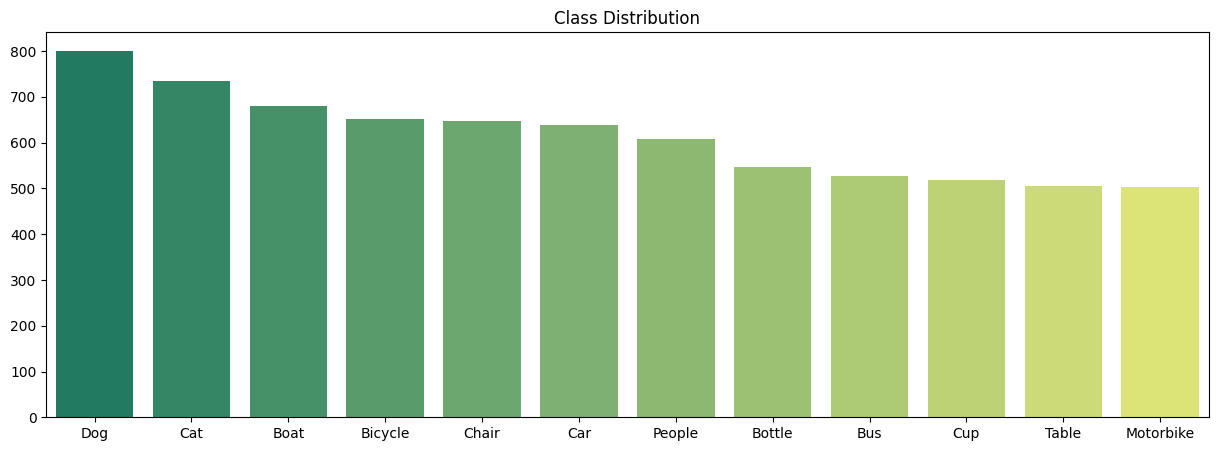

In [21]:
# Visulaize Class Dist
class_labels = dict(df['Class'].value_counts())

labels = []

count = []

for i,j in class_labels.items():

    labels.append(class_dict[i])

    count.append(j)

plt.figure(figsize=(15,5))
sns.barplot(x=labels,y=count,palette='summer')
plt.title('Class Distribution')
plt.show()

In [22]:
# function to get indoor/outdoor / lighting dist for each class
def get_class_analysis(label):

    global df
    df1 = df[df['Class']==label]

    in_out = dict(df1['In/Out'].value_counts())
    light_cond = dict(df1['Light'].value_counts())

    in_out_label =[]
    in_out_cnt =[]
    for i,j in in_out.items():
        in_out_label.append(in_out_dict[i])
        in_out_cnt.append(j)

    light_label = []
    light_cnt = []
    for i,j in light_cond.items():
        light_label.append(light_dict[i])
        light_cnt.append(j)

    print('In/Out Distribution:',in_out_label,in_out_cnt)
    print('Lightning Condt Distribution:',light_label,light_cnt)
    
    fig,axis = plt.subplots(2,1,figsize=(10,10))
    axis1 = sns.barplot(x=in_out_label,y=in_out_cnt,ax=axis[0])
    axis1.set_title('Indoor/outdoor Distribution')
    axis2 = sns.barplot(x=light_label,y=light_cnt,ax=axis[1])
    axis2.set_title('Lighting Condition Distribution')
    plt.show()

In/Out Distribution: ['Outdoor', 'Indoor'] [627, 25]
Lightning Condt Distribution: ['Strong', 'Ambient', 'Object', 'Weak', 'Single', 'Twilight', 'Shadow', 'Window', 'Low'] [326, 109, 64, 56, 50, 28, 8, 6, 5]


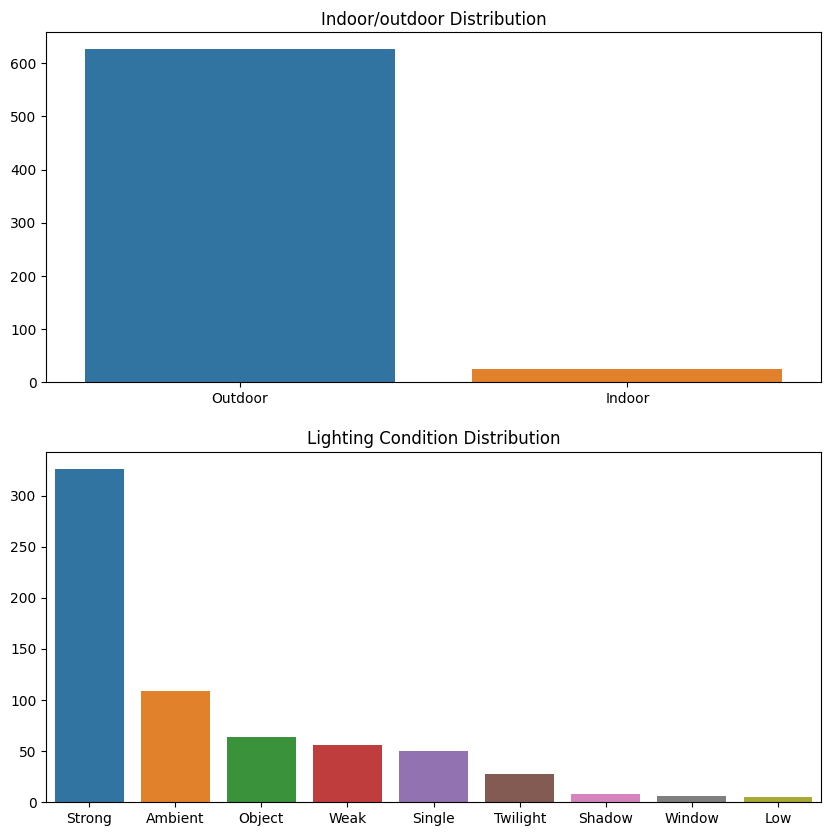

In [23]:
get_class_analysis(1) #Bicycle

In/Out Distribution: ['Outdoor', 'Indoor'] [676, 3]
Lightning Condt Distribution: ['Strong', 'Twilight', 'Ambient', 'Weak', 'Single', 'Object', 'Shadow', 'Low'] [277, 254, 73, 38, 24, 5, 5, 3]


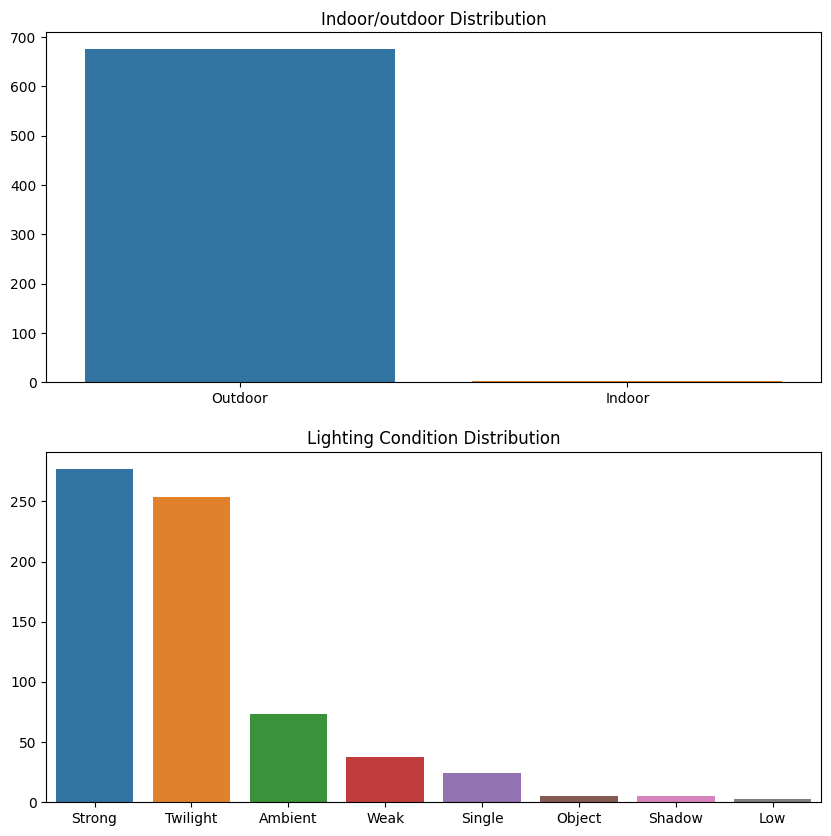

In [24]:
get_class_analysis(2) # Boat

In/Out Distribution: ['Indoor', 'Outdoor'] [438, 109]
Lightning Condt Distribution: ['Ambient', 'Single', 'Weak', 'Object', 'Strong', 'Low', 'Screen', 'Window', 'Twilight', 'Shadow'] [172, 100, 65, 61, 59, 39, 30, 13, 6, 2]


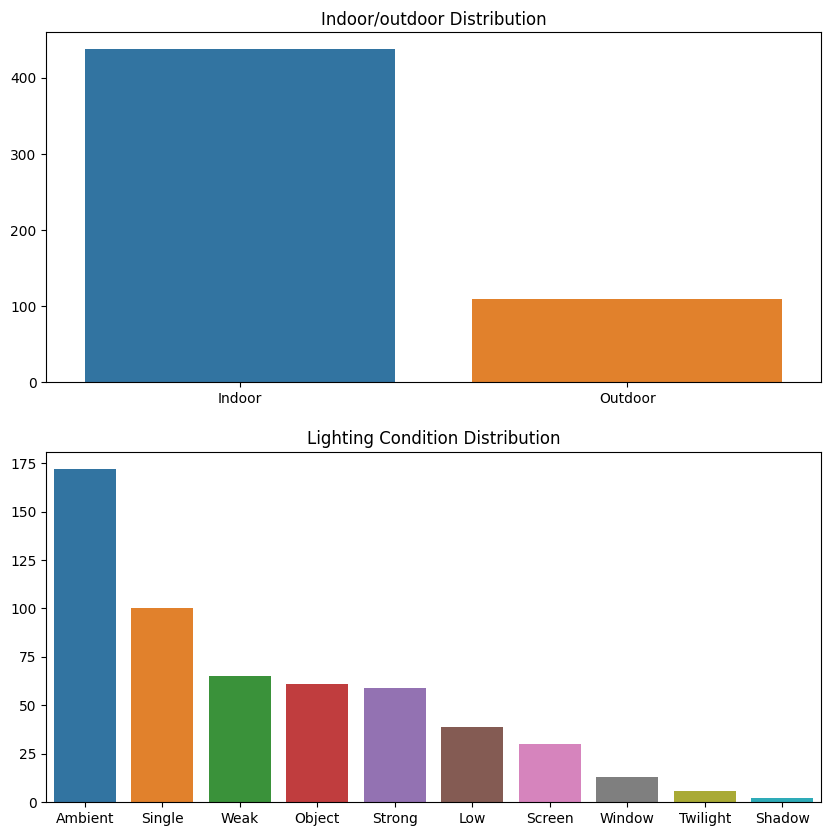

In [25]:
get_class_analysis(3) # Bottle

In [26]:
def plot_sample_images(label,n):
      images = []
      light = []
      global df
      df2 = df[df['Class']==label]

      for i in range(1,11):
          temp = list(df2[df2['Light']==i]['Name'])[0:n]
          if(len(temp)>2):
              for j in temp:
                  light.append(i)
                  images.append(j)

      fig, ax = plt.subplots(len(images)//n,n,figsize=(15,30),gridspec_kw={'wspace':0.01,'hspace':0.1})
      ax = ax.ravel()

      for i, img in enumerate(images):
          im_org = cv2.imread(img)
          try:
              im_resized = cv2.resize(im_org,(300,300),interpolation=cv2.INTER_LINEAR)
          except:
              continue
          ax[i].imshow(cv2.cvtColor(im_resized,cv2.COLOR_BGR2RGB),aspect='auto')
          ax[i].set_axis_off()
          ax[i].set_xlim(ax[i].get_xlim())
          ax[i].set_ylim(ax[i].get_ylim())
          ax[i].set_title(class_dict[label] + "/" + light_dict[light[i]])
      
      plt.show()

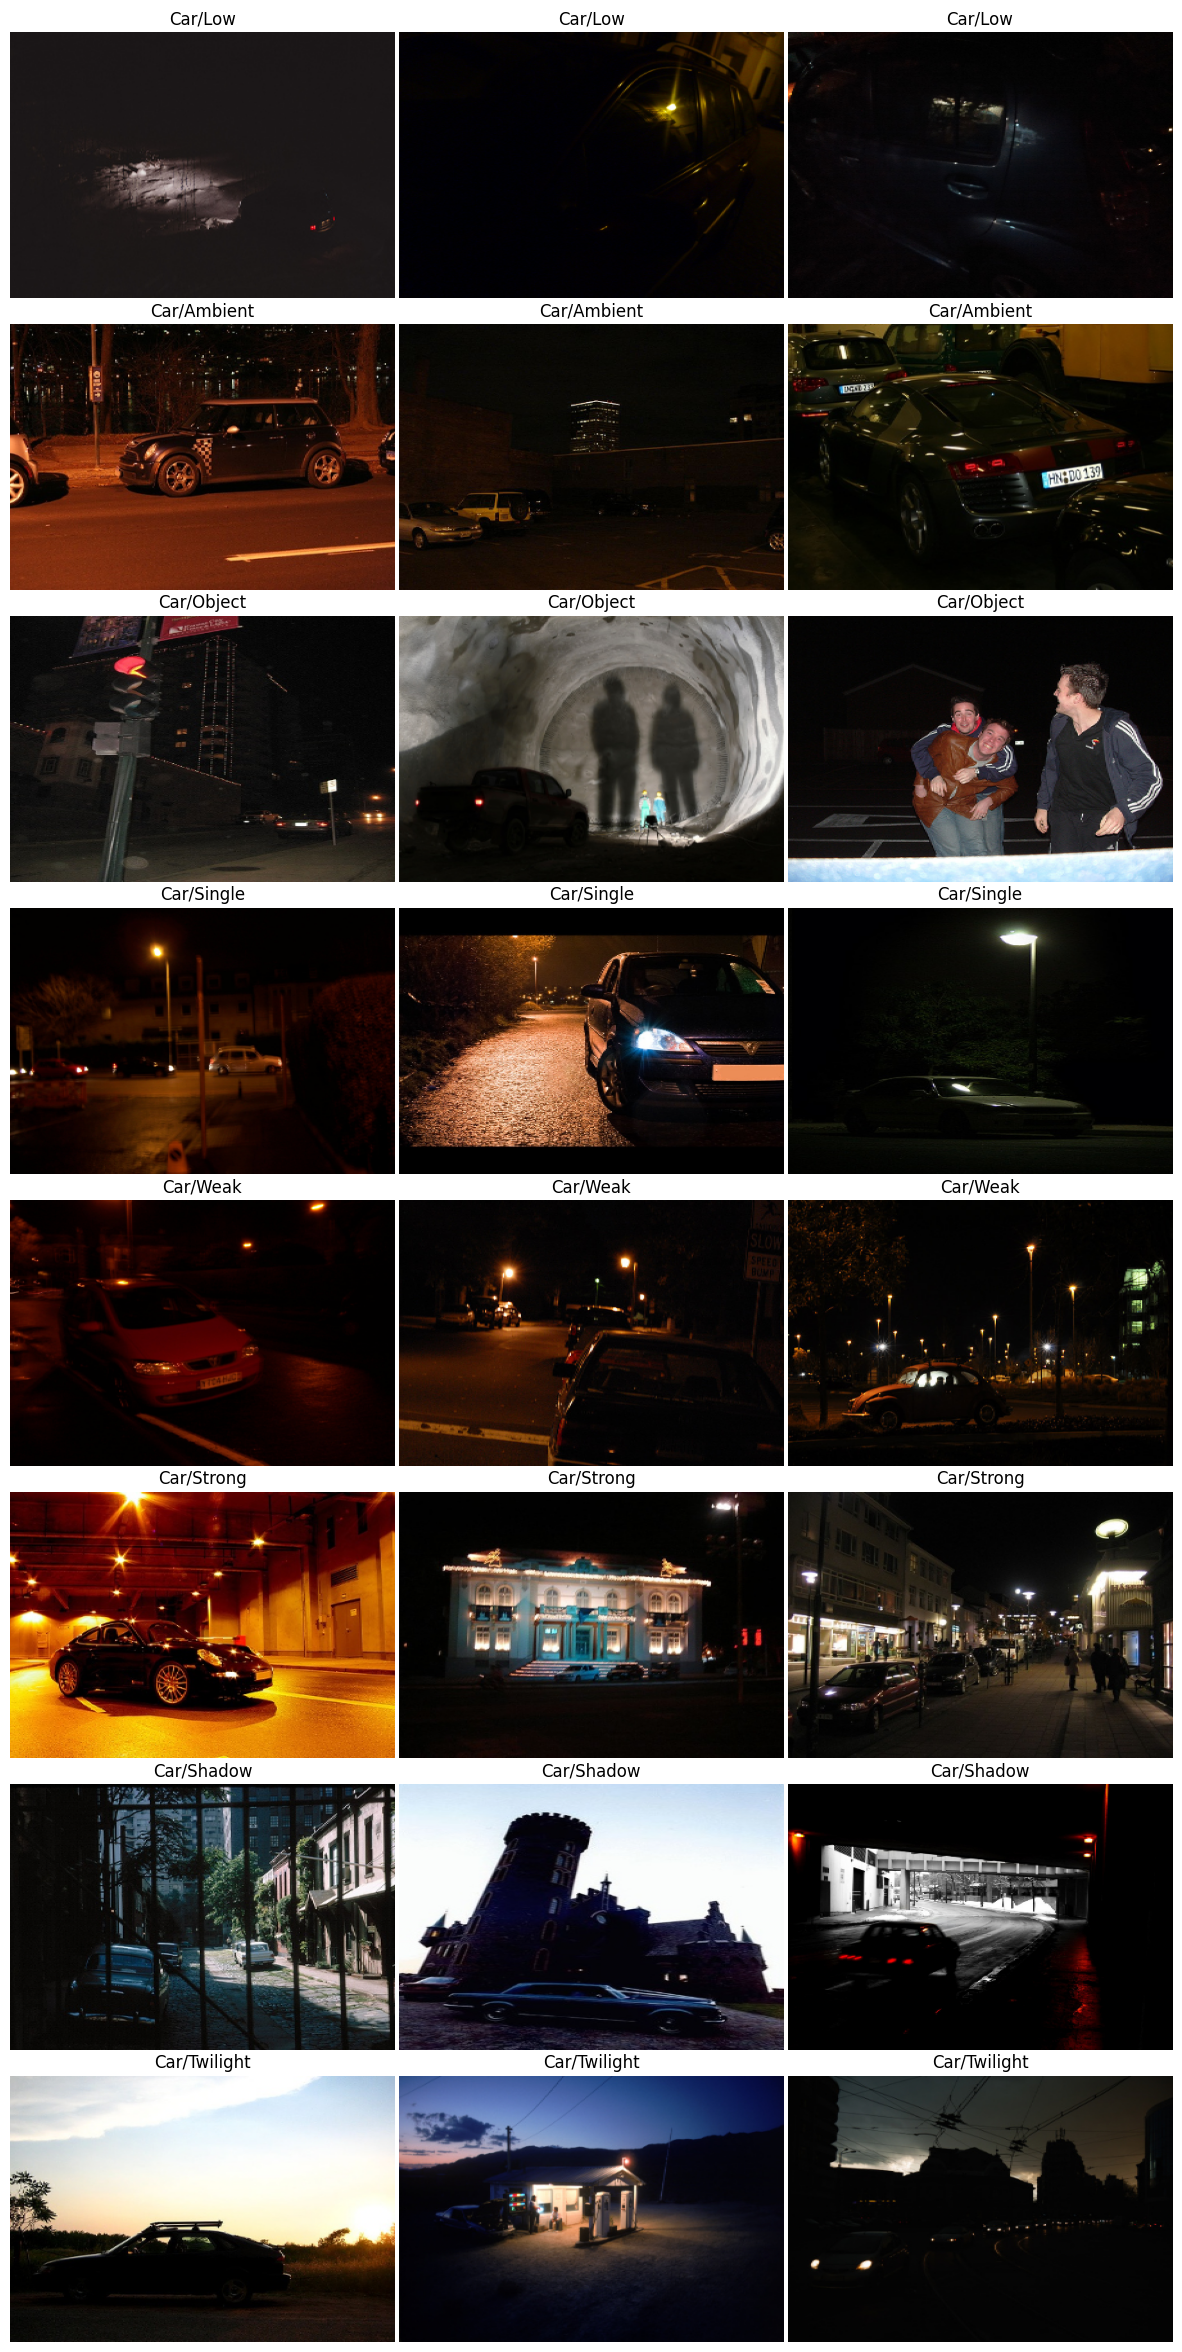

In [27]:
plot_sample_images(5,3)

In [28]:
os.chdir('/content/ExDark_Annno')
DIRS = os.listdir(os.getcwd())
print(DIRS)

['Dog', 'Motorbike', 'Table', 'Chair', 'Boat', 'Bicycle', 'Car', 'Cat', 'Cup', 'Bus', 'People', 'Bottle']


In [29]:
for dir in DIRS:
    dir = '/content/ExDark_Annno'+ '/' + dir
    if(os.path.isdir(dir)):
        os.chdir(dir)
        for filename in tqdm.tqdm(os.listdir(os.getcwd())):
            filename_str = str.split(filename, ".")[0]
            if filename.endswith(".txt"):
                  annotations = []
                  with open(filename) as f:
                      for idx,val in enumerate(f):
                          if(idx==0):
                            continue
                          class_label = val.split()[0]
                          if(class_label.lower() not in classes):
                            continue
                          val = val.replace(class_label,str(list(class_dict.keys())[list(class_dict.values()).index(class_label)]))
                          labels = val.split()
                          coords = np.asarray([float(labels[1]),float(labels[2]),float(labels[3]),float(labels[4])])
                          labels[1],labels[2],labels[3],labels[4] = coords[0], coords[1], coords[2], coords[3]
                          new_val = str(labels[0]) + "," + str(labels[1]) + "," +str(labels[2]) + "," + str(labels[3]) + "," + str(labels[4])
                          val = val.replace(val, new_val)
                          annotations.append(val)
                      f.close()
                  with open(filename,'w') as outfile:
                      for val in annotations:
                          outfile.write(val)
                          outfile.write('\n') 
                      outfile.close()       
        os.chdir('..')

100%|██████████| 547/547 [00:00<00:00, 4676.37it/s]


In [30]:
data = []
labels_arr = []
bboxes_arr = []
imagePaths = []

In [31]:
image_list = df['Name'].to_list()
imagePaths.extend(image_list)

In [32]:
for dir in DIRS:
    dir = '/content/ExDark_Annno'+ '/' + dir
    if(os.path.isdir(dir)):
        os.chdir(dir)
        for filename in tqdm.tqdm(os.listdir(os.getcwd())):
            filename_str = str.split(filename, ".")[0]
            if filename.endswith(".txt"):
                  annotations = []
                  coords = []
                  with open(filename) as f:
                      for idx,val in enumerate(f):
                          val_list = list(val.strip().split(','))
                          annotations.append(float(val_list[0]))
                          # annotations.append(class_dict[val_list[0]])
                          coords.append([float(val) for val in val_list[1:]])
                      f.close()
                  if(len(coords)>0 and len(annotations)>0):
                        bboxes_arr.append(coords)
                        labels_arr.append(annotations)
        os.chdir('..')

100%|██████████| 547/547 [00:00<00:00, 26913.37it/s]


In [33]:
bboxes = tuple(tuple(map(tuple,bbox)) for bbox in bboxes_arr)

In [34]:
print(len(bboxes))
bboxes

7362


(((214.0, 168.0, 209.0, 150.0),),
 ((246.0, 145.0, 127.0, 144.0),
  (190.0, 192.0, 67.0, 65.0),
  (114.0, 111.0, 248.0, 298.0)),
 ((853.0, 688.0, 51.0, 86.0),),
 ((396.0, 199.0, 237.0, 68.0),
  (280.0, 212.0, 109.0, 134.0),
  (581.0, 87.0, 44.0, 129.0)),
 ((59.0, 292.0, 490.0, 687.0),),
 ((29.0, 167.0, 86.0, 57.0),
  (108.0, 111.0, 68.0, 117.0),
  (192.0, 114.0, 35.0, 119.0),
  (225.0, 124.0, 36.0, 75.0),
  (231.0, 106.0, 73.0, 141.0),
  (317.0, 71.0, 134.0, 255.0),
  (459.0, 111.0, 57.0, 157.0)),
 ((255.0, 180.0, 267.0, 182.0),
  (40.0, 15.0, 281.0, 418.0),
  (101.0, 59.0, 526.0, 336.0)),
 ((183.0, 73.0, 135.0, 243.0),),
 ((251.0, 235.0, 136.0, 110.0), (159.0, 60.0, 115.0, 268.0)),
 ((130.0, 294.0, 70.0, 45.0),),
 ((327.0, 203.0, 150.0, 192.0), (161.0, 9.0, 131.0, 395.0)),
 ((104.0, 161.0, 232.0, 115.0),),
 ((53.0, 109.0, 210.0, 290.0),
  (264.0, 111.0, 64.0, 117.0),
  (254.0, 49.0, 102.0, 110.0)),
 ((714.0, 243.0, 103.0, 143.0), (223.0, 218.0, 259.0, 210.0)),
 ((1444.0, 901.0, 672.0,

In [35]:
data = np.asarray(data)
imagePaths = np.asarray(imagePaths)
labels = np.asarray([np.asarray(labels) for labels in labels_arr])

<ipython-input-35-3791e63f78a7>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.asarray([np.asarray(labels) for labels in labels_arr])


In [37]:
print(len(imagePaths))
imagePaths

7362


array(['/content/ExDark/Bicycle/2015_00001.png',
       '/content/ExDark/Bicycle/2015_00002.png',
       '/content/ExDark/Bicycle/2015_00003.png', ...,
       '/content/ExDark/Table/2015_07354.jpg',
       '/content/ExDark/Table/2015_07355.jpg',
       '/content/ExDark/Table/2017_07358.jpg'], dtype='<U41')

In [38]:
print(len(df))

7362


In [39]:
print(len(labels))
labels

7362


array([array([9.]), array([9., 9., 7.]), array([9.]), ...,
       array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
              3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])                   ,
       array([3., 3., 3., 7., 3.]), array([ 3., 11.])], dtype=object)

In [40]:
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow
import sys

In [41]:
# Train transforms
trn_tfms = A.Compose([
    A.ToGray(p=0.2),
    A.HorizontalFlip(),
    A.Rotate(limit=60),
    A.CLAHE(),
    A.IAASharpen(),
    A.IAAPerspective(),
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),
], p=1., bbox_params=A.BboxParams(format="pascal_voc"))

# Validation transforms
val_tfms = A.Compose([
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),   
], p=1., bbox_params=A.BboxParams(format="pascal_voc"))

/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)


In [42]:
class ExDarkData(Dataset):
    def __init__(self, data, trn:bool=False):
        self.data = data
        if trn:  self.tfms = trn_tfms
        else:    self.tfms = val_tfms
                
    def __len__(self) -> int:
        return len(self.data[0])

    def __getitem__(self, idx):

        image_idx = self.data[0][idx]
        labels = self.data[1][idx]
        bbox = self.data[2][idx]

        # read in the image
        im = cv2.cvtColor(cv2.imread(image_idx), cv2.COLOR_BGR2RGB)
        im /= 255.0

        wt,ht,c = im.shape

        width = bbox[:,2]
        height = bbox[:,3]

        bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
        bbox[:, 3] = bbox[:, 1] + bbox[:, 3]

        bbox[:,0] = (bbox[:,0]/width)
        bbox[:,1] = (bbox[:,1]/height)
        bbox[:,2] = (bbox[:,2]/width)
        bbox[:,3] = (bbox[:,3]/height)

        bboxes = []
        for i in range(len(bbox)):
          temp = list(bbox[i])
          temp.append(int(labels[i]))
          bboxes.append(temp)

        # apply transfromations
        trns = self.tfms(image=im, bboxes=bboxes)
        try: 
          im, bboxes = trns["image"], trns["bboxes"][:,:4]
        except : 
            print(trns["image"])
            print(trns["bboxes"])
            print(f"[INFO] Something wrong ... {self.df.filename[idx]}")
            im = trns["image"]
            bboxes = [0,0,2,2]

        image_id = torch.tensor([idx])
        trgt = torch.tensor(self.data[1][idx], dtype=torch.int64)

        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)

        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)

        # Create target dictionary
        target = {}
        target["boxes"] = bboxes
        target["labels"] = trgt
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return im, target

In [43]:
train_count

4799

In [44]:
test_count

2563

In [ ]:
os.chdir("/content/vision/references/detection/")

from typing import Dict, Tuple, Sequence, Union
from engine import evaluate
from IPython import display
import utils
import warnings
warnings.filterwarnings("ignore")

# from engine import train_one_epoch